In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [14]:
import torch

# Define o device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [15]:
from torchvision import datasets, transforms
import torch

data_path = './data/'

mnist = datasets.MNIST(
    data_path, train=True, download=True,
    transform=transforms.ToTensor()
)

# Empilha todas as imagens: [N, 1, 28, 28] = [batch size, canais, altura, largura] e manda para GPU
images = torch.stack([img for img, _ in mnist], dim=0).to(device)
# Calcula a média e o desvio padrão
mean = images.mean()
std = images.std()

mean, std

(tensor(0.1307, device='cuda:0'), tensor(0.3081, device='cuda:0'))

In [16]:
# Dividimos o dataset em dois conjuntos: treinamento e validação/teste
# Aplicamos normalização usando a média e desvio padrão calculados

# treino
mnist_train = datasets.MNIST(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

# validacao/teste
mnist_val = datasets.MNIST(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Cria um DataLoader:
# - o dataset é dividido em batches de 64 imagens
# - os dados são embaralhados no início de cada época
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=2048, shuffle=True)

# Define nosso modelo como uma classe (MLP)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # camadas lineares
        self.fc1 = nn.Linear(28*28, 512)   # entrada: 784 -> 512
        self.fc2 = nn.Linear(512, 256)     # 512 -> 256
        self.fc3 = nn.Linear(256, 10)      # 256 -> 10 classes
        # função de ativação
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # achatando a imagem: [batch, 1, 28, 28] -> [batch, 784]
        x = x.view(x.shape[0], -1)
        # passagem pelas camadas
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # última camada sem ativação (CrossEntropyLoss aplica softmax internamente)
        return x

# cria o modelo e envia para GPU
model = MLP().to(device)

# learning rate controla o quanto os parâmetros do modelo são atualizados durante o treinamento
learning_rate = 0.1

# otimizador Stochastic Gradient Descent (SGD):
# responsável por atualizar os parâmetros usando os gradientes calculados a partir de cada batch
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# função de perda Cross-Entropy (comumente usada para classificação)
# calcula a diferença entre as probabilidades previstas pelo modelo e os rótulos verdadeiros
loss_fn = nn.CrossEntropyLoss()

# número de épocas de treino
n_epochs = 30


In [ ]:
# loop de treino

for epoch in range(n_epochs):
    # itera sobre batches de imagens e rótulos
    for imgs, labels in train_loader:
        # envia os dados para o mesmo dispositivo do modelo (CPU ou GPU)
        imgs = imgs.to(device)
        labels = labels.to(device)

        # calcula a previsão do modelo
        outputs = model(imgs)

        # calcula a perda
        loss = loss_fn(outputs, labels)

        # reseta os gradientes para evitar acumulação
        optimizer.zero_grad()
        
        # calcula os gradientes da perda
        loss.backward()
        
        # atualiza os parâmetros
        optimizer.step()

    # imprime a perda ao final de cada época
    print("Época: %d, Perda: %f" % (epoch, float(loss)))

    # tempo final GPU: 10m 18.1s


/tmp/ipykernel_964/3008569929.py:26: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("Época: %d, Perda: %f" % (epoch, float(loss)))


Época: 0, Perda: 0.656122
Época: 1, Perda: 0.442225
Época: 2, Perda: 0.299253
Época: 3, Perda: 0.286117
Época: 4, Perda: 0.284164
Época: 5, Perda: 0.221256
Época: 6, Perda: 0.250589
Época: 7, Perda: 0.235535
Época: 8, Perda: 0.200524
Época: 9, Perda: 0.253328
Época: 10, Perda: 0.161290
Época: 11, Perda: 0.200339
Época: 12, Perda: 0.273289
Época: 13, Perda: 0.200811
Época: 14, Perda: 0.120875
Época: 15, Perda: 0.143664
Época: 16, Perda: 0.152167
Época: 17, Perda: 0.185374
Época: 18, Perda: 0.169242
Época: 19, Perda: 0.159727
Época: 20, Perda: 0.174853
Época: 21, Perda: 0.076417
Época: 22, Perda: 0.136360
Época: 23, Perda: 0.111890
Época: 24, Perda: 0.096507
Época: 25, Perda: 0.062580
Época: 26, Perda: 0.102596
Época: 27, Perda: 0.120488
Época: 28, Perda: 0.096767
Época: 29, Perda: 0.085882


In [19]:
# avaliação do modelo no conjunto de treino
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Acurácia no treino: %.2f%%" % (100 * correct / total))


Acurácia no treino: 97.45%


In [20]:
# avaliação do modelo no conjunto de validação
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print("Acurácia na validação: %.2f%%" % (100 * correct / total))


Acurácia na validação: 96.87%


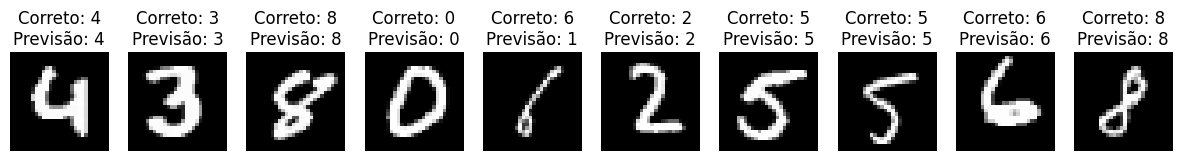

In [22]:
import random
from matplotlib import pyplot as plt

num_imgs = 10

plt.figure(figsize=(15, 3))

for i in range(num_imgs):
    # escolhe índice aleatório
    idx = random.randint(0, len(mnist_val)-1)
    
    # pega imagem e rótulo verdadeiro
    img, label = mnist_val[idx]
    
    # envia para o device e adiciona dimensão de batch
    img_tensor = img.unsqueeze(0).to(device)
    
    # passa pelo modelo
    with torch.no_grad():
        output = model(img_tensor)
        predicted = torch.argmax(output, dim=1).item()
    
    # mostra imagem
    plt.subplot(1, num_imgs, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Correto: {label}\nPrevisão: {predicted}")
    plt.axis('off')

plt.show()
